In [0]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import itertools
import functools
import re
import warnings
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
import pprint

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

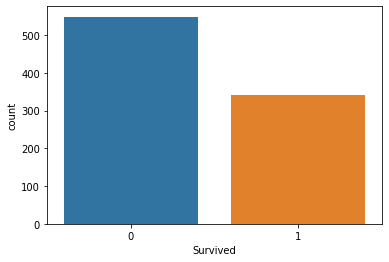

In [3]:
sns.countplot(train.Survived);

In [4]:
train.shape, test.shape

((891, 12), (418, 11))

In [5]:
train.groupby(['Pclass', 'Survived'])['Fare'].agg(['max', 'min', 'median', 'mean', 'count'])
#средняя и максимум цена билета выжившего больше

max      min   median       mean  count
Pclass Survived                                              
1      0         263.0000   0.0000  44.7500  64.684008     80
       1         512.3292  25.9292  77.9583  95.608029    136
2      0          73.5000   0.0000  13.0000  19.412328     97
       1          65.0000  10.5000  21.0000  22.055700     87
3      0          69.5500   0.0000   8.0500  13.669364    372
       1          56.4958   0.0000   8.5167  13.694887    119

In [6]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [7]:
train.Embarked.unique(), test.Embarked.unique()

(array(['S', 'C', 'Q', nan], dtype=object),
 array(['Q', 'S', 'C'], dtype=object))

In [0]:
train['cabin_is_none'] = train.Cabin.isnull().astype('int32') 
test['cabin_is_none'] = test.Cabin.isnull().astype('int32') 

In [9]:
print('ПРОПУСКИ: \n column: train - test')
cols = train.drop('Survived', axis = 1).columns
for col, tr, ts in zip(cols, train[cols].isnull().sum(), test.isnull().sum()):
    print(f'{col}: {tr} - {ts}')

ПРОПУСКИ: 
 column: train - test
PassengerId: 0 - 0
Pclass: 0 - 0
Name: 0 - 0
Sex: 0 - 0
Age: 177 - 86
SibSp: 0 - 0
Parch: 0 - 0
Ticket: 0 - 0
Fare: 0 - 1
Cabin: 687 - 327
Embarked: 2 - 0
cabin_is_none: 0 - 0


In [10]:
train[train.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cabin_is_none
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,0
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,0


In [11]:
#train[(train.Pclass == 1) & (train.Sex == 'female') & (train.Survived == 1) & (train.SibSp == 0) & (train.Parch == 0)
#     & (train.Age <= 70) & (train.Age >= 57)]


print(train[train.Embarked.isnull()])
#для Cabin, Ticket Embarked , Fare является уникальным значением
#train.drop(train[train.Embarked.isnull()].index, axis = 0, inplace = True)

train.loc[61, 'Embarked'] = 'C'
train.loc[829, 'Embarked'] = 'S'

into = {
       'S': 1, 
       'C': 2,
       'Q': 3
       } #титаник S->C->Q 
for df in [train, test]:
    df.Embarked = df.Embarked.map(into)

     PassengerId  Survived  Pclass                                       Name  \
61            62         1       1                        Icard, Miss. Amelie   
829          830         1       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket  Fare Cabin Embarked  cabin_is_none  
61   female  38.0      0      0  113572  80.0   B28      NaN              0  
829  female  62.0      0      0  113572  80.0   B28      NaN              0  


In [12]:
print(train.Sex.unique(), test.Sex.unique())
train.Sex = train.Sex.map({'male': 1, 'female': 0})
test.Sex = test.Sex.map({'male': 1, 'female': 0})

['male' 'female'] ['male' 'female']


In [0]:
#создание признака индикатора
train['status_person'] = train.Name.apply(lambda s: re.findall('\w+[.]', s)[0])
test['status_person'] = test.Name.apply(lambda s: re.findall('\w+[.]', s)[0])

In [14]:
train.status_person.value_counts(), test.status_person.value_counts()

(Mr.          517
 Miss.        182
 Mrs.         125
 Master.       40
 Dr.            7
 Rev.           6
 Mlle.          2
 Col.           2
 Major.         2
 Countess.      1
 Sir.           1
 Jonkheer.      1
 Capt.          1
 Lady.          1
 Don.           1
 Mme.           1
 Ms.            1
 Name: status_person, dtype: int64, Mr.        240
 Miss.       78
 Mrs.        72
 Master.     21
 Rev.         2
 Col.         2
 Ms.          1
 Dona.        1
 Dr.          1
 Name: status_person, dtype: int64)

rev - священник 
mrs - замужная женщина
miss - не замужнаяя женщина
ms - разведенная и вдовы или не известен семейный статус
mr - мужчина
capt - капитан
dr - доктор
col - военный
sir - мужчина с титулом
lady - к женщинам вежливое обращение с титутлом
master - мальчики дл 16 лет
mme - мадам
Jonkheer - низкий титул в дворянстве
don, dona - титул знатити для муж и жен соотвественно
Countess - графиня
milli - мадмуазель 

In [15]:
train.groupby('status_person')['Survived'].value_counts()
#больше всего выживали женщ. погибали со во всех случаях священники 

status_person  Survived
Capt.          0             1
Col.           0             1
               1             1
Countess.      1             1
Don.           0             1
Dr.            0             4
               1             3
Jonkheer.      0             1
Lady.          1             1
Major.         0             1
               1             1
Master.        1            23
               0            17
Miss.          1           127
               0            55
Mlle.          1             2
Mme.           1             1
Mr.            0           436
               1            81
Mrs.           1            99
               0            26
Ms.            1             1
Rev.           0             6
Sir.           1             1
Name: Survived, dtype: int64

In [16]:
train[train.status_person == 'Rev.']
#все из 2-ого класс, кроме 1 садились в 1 городе и у всех не указана кабина

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cabin_is_none,status_person
149,150,0,2,"Byles, Rev. Thomas Roussel Davids",1,42.0,0,0,244310,13.000,NaN,1,1,Rev.
150,151,0,2,"Bateman, Rev. Robert James",1,51.0,0,0,S.O.P. 1166,12.525,NaN,1,1,Rev.
249,250,0,2,"Carter, Rev. Ernest Courtenay",1,54.0,1,0,244252,26.000,NaN,1,1,Rev.
626,627,0,2,"Kirkland, Rev. Charles Leonard",1,57.0,0,0,219533,12.350,NaN,3,1,Rev.
848,849,0,2,"Harper, Rev. John",1,28.0,0,1,248727,33.000,NaN,1,1,Rev.
886,887,0,2,"Montvila, Rev. Juozas",1,27.0,0,0,211536,13.000,NaN,1,1,Rev.


In [17]:
train[train.status_person == 'Capt.']#не капитан титаника

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cabin_is_none,status_person
745,746,0,1,"Crosby, Capt. Edward Gifford",1,70.0,1,1,WE/P 5735,71.0,B22,1,0,Capt.


In [0]:
men_group = ['Sir.', 'Mr.', 'Don.'] #мужчины
woman_group = ['Mmr.', 'Ms.', 'Mrs.'] #женщины
woman_group_nobility = ['Mme.', 'Lady.', 'Dona.', 'Countess.'] #женщины знати
girls_group = ['Miss.', 'Mlle.'] # не замужные девушки 
mil_group = ['Capt.', 'Col.', 'Major.', 'Dr.'] #военные и врачи
rev_group = ['Rev.'] #священники(не много, но все погибли)
boys_group = ['Master.', 'Jonkheer.'] #юноши

#nobility = woman_group_nobility + ['Sir', 'Don.', 'Jonkheer.']

group_status = dict(collections.ChainMap({val: 'mr' for val in men_group},
        {val: 'ms' for val in woman_group + woman_group_nobility},
        {val: 'miss' for val in girls_group},
        {val: 'military' for val in mil_group},
        {val: 'rev' for val in rev_group},
        {val: 'master' for val in boys_group}))

#train['nobility'] = train.status_person.apply(lambda s: 1 if s in nobility else 0)
#test['nobility'] = test.status_person.apply(lambda s: 1 if s in nobility else 0)

train.status_person = train.status_person.map(group_status)
test.status_person = test.status_person.map(group_status)

In [19]:
pd.concat([train.groupby(['status_person', 'Pclass']).Fare.agg(['mean', 'median', 'min', 'max', 'count']).reset_index(), 
           test.groupby(['status_person', 'Pclass']).Fare.agg(['mean', 'median', 'min', 'max', 'count']).reset_index()], 
          axis = 1)

,status_person,Pclass,mean,median,min,max,count,status_person,Pclass,mean,median,min,max,count
0,master,1,88.352075,100.92915,0.0000,151.5500,4,master,1.0,198.437500,198.43750,134.5000,262.3750,2.0
1,master,2,27.306022,26.00000,14.5000,39.0000,9,master,2.0,27.750000,27.75000,23.0000,32.5000,2.0
2,master,3,28.177232,28.51250,8.5167,69.5500,28,master,3.0,20.941171,15.24580,3.1708,69.5500,17.0
3,military,1,50.977920,33.00000,25.9292,133.6500,10,military,1.0,112.627767,81.85830,28.5000,227.5250,3.0
4,military,2,12.250000,12.25000,10.5000,14.0000,2,miss,1.0,149.329471,158.20835,26.5500,263.0000,14.0
5,miss,1,121.694356,88.25000,26.2833,512.3292,48,miss,2.0,27.199219,24.50000,13.0000,65.0000,16.0
6,miss,2,20.393750,13.00000,10.5000,65.0000,34,miss,3.0,12.521962,7.87920,6.9500,69.5500,48.0
7,miss,3,15.248043,8.75625,6.7500,69.5500,102,mr,1.0,68.724521,50.24790,0.0000,262.3750,52.0
8,mr,1,67.562653,42.40000,0.0000,512.3292,109,mr,2.0,19.951410,13.00000,9.6875,73.5000,59.0
9,mr,2,19.252564,13.00000,0.0000,73.5000,91,mr,3.0,10.615788,7.85420,6.4375,69.5500,128.0


In [20]:
pd.concat([train.groupby(['status_person', 'Pclass']).Age.agg(['mean', 'median', 'min', 'max', 'count']).reset_index(), 
           test.groupby(['status_person', 'Pclass']).Age.agg(['mean', 'median', 'min', 'max', 'count']).reset_index()], 
          axis = 1)

,status_person,Pclass,mean,median,min,max,count,status_person,Pclass,mean,median,min,max,count
0,master,1,13.480000,7.5,0.92,38.0,4,master,1.0,9.500000,9.5,6.00,13.0,2.0
1,master,2,2.258889,1.0,0.67,8.0,9,master,2.0,5.000000,5.0,2.00,8.0,2.0
2,master,3,5.350833,4.0,0.42,12.0,24,master,3.0,7.454615,7.0,0.33,14.5,13.0
3,military,1,50.888889,50.0,32.00,70.0,9,military,1.0,51.000000,53.0,47.00,53.0,3.0
4,military,2,38.500000,38.5,23.00,54.0,2,miss,1.0,31.428571,32.0,21.00,45.0,14.0
5,miss,1,29.744681,30.0,2.00,63.0,47,miss,2.0,17.370000,19.5,0.92,31.0,16.0
6,miss,2,22.390625,24.0,2.00,50.0,32,miss,3.0,19.872647,22.0,0.17,38.0,34.0
7,miss,3,16.123188,18.0,0.75,45.0,69,mr,1.0,41.200000,42.0,17.00,67.0,45.0
8,mr,1,41.646067,40.0,17.00,80.0,89,mr,2.0,31.718182,28.0,14.00,63.0,55.0
9,mr,2,32.768293,31.0,16.00,70.0,82,mr,3.0,27.198795,25.0,14.00,60.5,83.0


In [21]:
train.groupby('status_person').Survived.value_counts()

status_person  Survived
master         1            23
               0            18
military       0             7
               1             5
miss           1           129
               0            55
mr             0           437
               1            82
ms             1           103
               0            26
rev            0             6
Name: Survived, dtype: int64

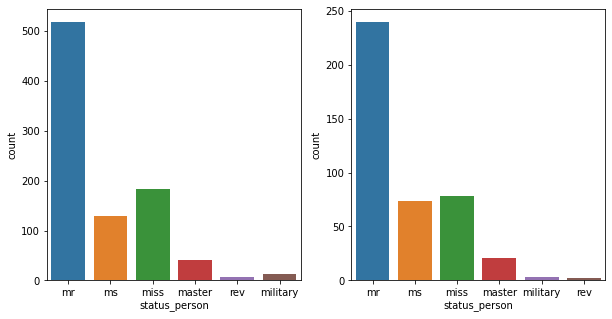

In [22]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
sns.countplot(data = train, x = 'status_person', ax = ax[0])
sns.countplot(data = test, x = 'status_person', ax = ax[1]);

In [0]:
#количество кабин
for df in [train, test]:
    df['count_cabin'] = df.Cabin.apply(lambda s: 0 if isinstance(s, float) else len(s.split(' ')))

In [0]:
#какие буквы входят в Cabin
for df in [train, test]:
    for char in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
        df[f'is_{char}'] = df.Cabin.apply(lambda s: 0 if isinstance(s, float) else collections.Counter(s).get(char, 0))

In [0]:
#цифры в Cabin, можно видеть, что если указано несколько кабин, то они близки друг к другу
for df in [train, test]:
    g = lambda s: re.findall('(\d+)', s) if len(re.findall('(\d+)', s)) != 0 else ['0']
    f = lambda s: np.apply_along_axis(np.vectorize(int), 0, g(s))
    df['mean_cabin'] = df.Cabin.apply(lambda s: -1 if isinstance(s, float) else f(s).mean())

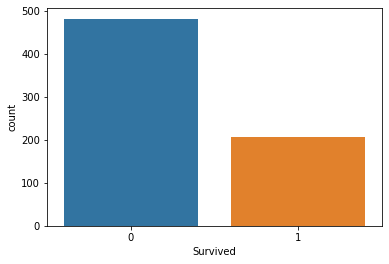

In [26]:
sns.countplot(train[(train[['is_A', 'is_B', 'is_C', 'is_D', 'is_E', 'is_F', 'is_G']].sum(axis = 1) == 0).astype(bool)].Survived);

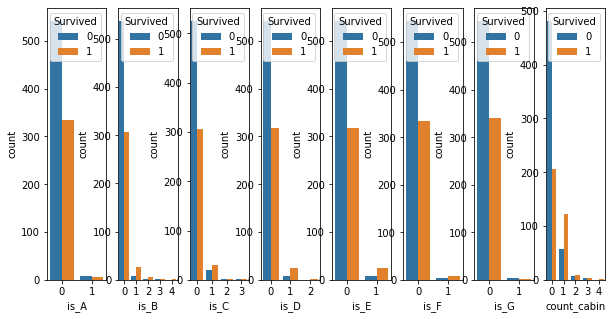

In [27]:
fig, ax = plt.subplots(1, 8, figsize = (10, 5))
for i, col in enumerate(['is_A', 'is_B', 'is_C', 'is_D', 'is_E', 'is_F', 'is_G', 'count_cabin']):
    sns.countplot(data = train, hue = 'Survived', x = col, ax = ax[i])
    
#в кабине E, D больше выживало 

In [0]:
test.Fare.fillna(6.2375, inplace = True) 
#число было выбрано из условия train[(train.Pclass == 3) & (train.Cabin.isnull()) & (train.Sex == 1) & (train.Age > 60)]

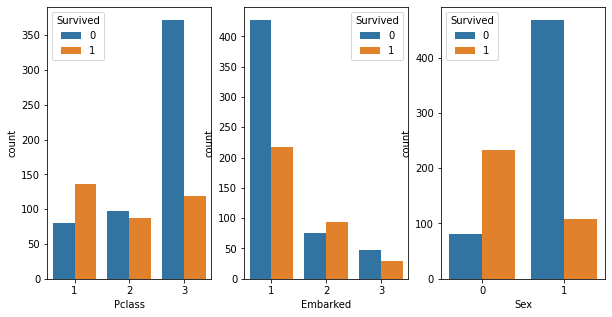

In [29]:
fig, ax = plt.subplots(1, 3, figsize = (10, 5))
for i, col in enumerate(['Pclass', 'Embarked', 'Sex']):
    sns.countplot(data = train, x = col, hue = 'Survived', ax = ax[i])

In [30]:
#отношение людей без определенного возраста к целевой переменной
train[train.Age.isnull()].Survived.value_counts() 

0    125
1     52
Name: Survived, dtype: int64

In [0]:
into = train.groupby(['status_person', 'Pclass']).Age.agg(['mean', 'median', 'min', 'max', 'count'])

for idx in train[train.Age.isnull()].index:
    train.loc[idx, 'Age'] = into.loc[train.loc[idx, 'status_person'], train.loc[idx, 'Pclass']]['mean']

for idx in test[test.Age.isnull()].index:
    test.loc[idx, 'Age'] = into.loc[test.loc[idx, 'status_person'], test.loc[idx, 'Pclass']]['mean']

In [0]:
for df in [train, test]:
    df['family'] = df.SibSp + df.Parch
    df['alone'] = (df.family == 0).astype('int32')

In [33]:
train.groupby('Survived')['family'].value_counts(), train.groupby('Survived')['alone'].value_counts()
#отсутсвие семьи повышало шансы выжить

(Survived  family
 0         0         374
           1          72
           2          43
           5          19
           4          12
           3           8
           6           8
           10          7
           7           6
 1         0         163
           1          89
           2          59
           3          21
           6           4
           4           3
           5           3
 Name: family, dtype: int64, Survived  alone
 0         1        374
           0        175
 1         0        179
           1        163
 Name: alone, dtype: int64)

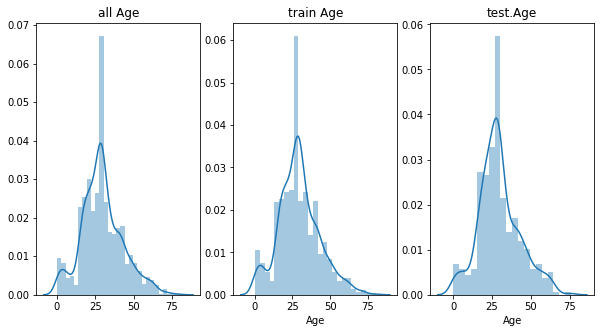

In [34]:
#отдаленно чем-то походит на  нормальное 
fig, ax = plt.subplots(1, 3, figsize = (10, 5))
sns.distplot(list(train.Age.values) + list(test.Age.values), ax = ax[0])
ax[0].set_title('all Age')
sns.distplot(train.Age, ax = ax[1])
ax[1].set_title('train Age')
sns.distplot(test.Age, ax = ax[2])
ax[2].set_title('test.Age');

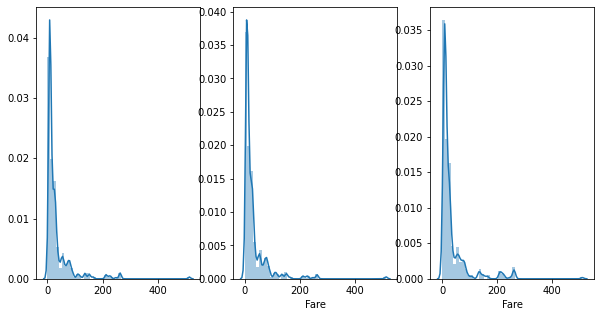

In [35]:
#возможно нужно использовать логарифм и видны у хвоста небольшие скачки, мб какие-то выделяющиеся значения(1 класс)
fig, ax = plt.subplots(1, 3, figsize = (10, 5))
sns.distplot(list(train.Fare.values) + list(test.Fare.values), ax = ax[0])
sns.distplot(train.Fare, ax = ax[1])
sns.distplot(test.Fare, ax = ax[2]);

In [36]:
train.groupby('Survived')[['Fare', 'Age', 'mean_cabin']].agg(['mean', 'median','min', 'max', 'std'])

Fare                                         Age             \
               mean median  min       max        std       mean     median   
Survived                                                                     
0         22.117887   10.5  0.0  263.0000  31.388207  30.257916  28.724891   
1         48.395408   26.0  0.0  512.3292  66.596998  28.100624  28.362445   

                                mean_cabin                                
           min   max        std       mean median  min    max        std  
Survived                                                                  
0         1.00  74.0  12.935571   5.601093   -1.0 -1.0  128.0  21.576195  
1         0.42  80.0  14.408899  18.630117   -1.0 -1.0  148.0  33.037983

In [0]:
train['ticket_number'] = train.Ticket.apply(lambda x: int(x.lower().replace('/', '').replace('.', '').split(' ')[1]) if len(x.split(' ')) == 2 else -1)
test['ticket_number'] = test.Ticket.apply(lambda x: int(x.lower().replace('/', '').replace('.', '').split(' ')[1]) if len(x.split(' ')) == 2 else -1)

In [0]:
train['ticket_prefix'] = train.Ticket.apply(lambda x: x.lower().replace('/', '').replace('.', '').split(' ')[0] if len(x.split(' ')) == 2 else np.nan)
test['ticket_prefix'] = train.Ticket.apply(lambda x: x.lower().replace('/', '').replace('.', '').split(' ')[0] if len(x.split(' ')) == 2 else np.nan)

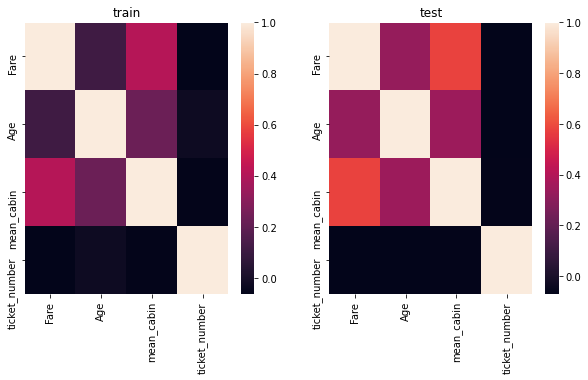

In [39]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
sns.heatmap(train[['Fare', 'Age', 'mean_cabin', 'ticket_number']].corr(), ax = ax[0])
ax[0].set_title('train')
sns.heatmap(test[['Fare', 'Age', 'mean_cabin', 'ticket_number']].corr(), ax = ax[1])
ax[1].set_title('test');

In [0]:
#train['Age_minus_Fare'] = train.Fare - train.Age
#train['Age_minus_Cabin'] = train.Age - train.mean_cabin

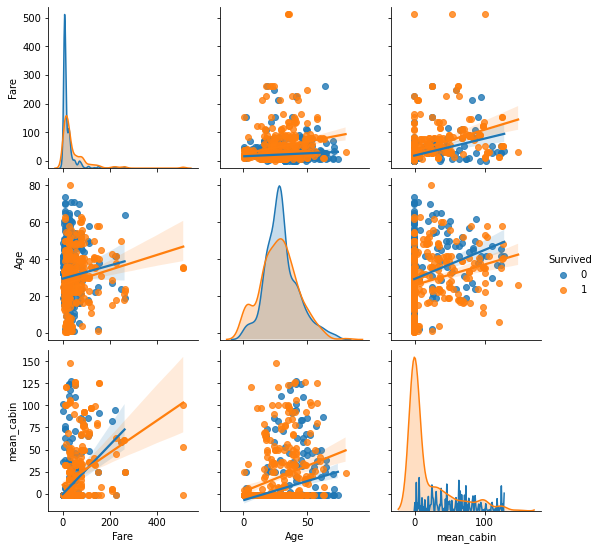

In [41]:
sns.pairplot(train, vars = ['Fare', 'Age', 'mean_cabin'], kind = 'reg', hue = 'Survived');

In [42]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cabin_is_none,status_person,count_cabin,is_A,is_B,is_C,is_D,is_E,is_F,is_G,mean_cabin,family,alone,ticket_number,ticket_prefix
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,1,1,mr,0,0,0,0,0,0,0,0,-1.0,1,0,21171,a5
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,2,0,ms,1,0,0,1,0,0,0,0,85.0,1,0,17599,pc
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,1,1,miss,0,0,0,0,0,0,0,0,-1.0,0,1,3101282,stono2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,1,0,ms,1,0,0,1,0,0,0,0,123.0,1,0,-1,NaN
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,1,1,mr,0,0,0,0,0,0,0,0,-1.0,0,1,-1,NaN


In [43]:
def dice(series1, series2):
    intersection = np.sum(series1 * series2)                  
    return 2 * intersection  / (np.sum(series1) + np.sum(series2))

def jaccard(series1, series2):
    intersection = np.sum(series1 * series2)
    union = np.sum(series1 + series2)
    return intersection / (union - intersection)



jaccard(train.Survived, train.Sex), dice(train.Survived, train.cabin_is_none)                                           

(0.1345679012345679, 0.4003887269193392)

In [0]:
bin_features = ['Survived', 'Sex', 'cabin_is_none', 'is_A',
       'is_B', 'is_C', 'is_D', 'is_E', 'is_F', 'is_G', 'alone']

result_bin_metrics = pd.DataFrame(columns = ['feature1', 'feature2', 'jaccard', 'dice'])

for f1, f2 in itertools.combinations(bin_features, 2):
    result_bin_metrics = result_bin_metrics.append({
        'feature1': f1,
        'feature2': f2,
        'jaccard': jaccard(train[f1], train[f2]), 
        'dice': dice(train[f1], train[f2]) 
    }, ignore_index = True)

In [45]:
result_bin_metrics.sort_values(by = 'dice', ascending = False)
#отсутсвие указанной кабины и семьи коррелирует с таргетом

,feature1,feature2,jaccard,dice
10,Sex,cabin_is_none,0.591940,0.743671
18,Sex,alone,0.584637,0.737882
26,cabin_is_none,alone,0.567222,0.723856
1,Survived,cabin_is_none,0.250304,0.400389
9,Survived,alone,0.227654,0.370876
52,is_F,is_G,0.176471,0.300000
0,Survived,Sex,0.134568,0.237214
3,Survived,is_B,0.134078,0.236453
4,Survived,is_C,0.110215,0.198547
5,Survived,is_D,0.074286,0.138298


In [46]:
def bayes_variable(data: 'pd.DataFrame', x: str, y: str) -> None:
    l = len(train)
    priory = {val: len(data[data[x] == val])/ l for val in data[x].unique()}
    group = train.groupby(x)[y].value_counts()
    for i in data[y].unique():
        full = sum([val * group.get((key, i), 0) / group.get(key).sum() for key, val in priory.items()])
        for key in priory.keys():
            posterior = group.get((key, i), 0) / group.get(key).sum() * priory.get(key)
            print(f'вероятность {y} = {i} при {x} = {key} : {posterior}')
            
bayes_variable(data = train, x = 'is_C', y = 'Survived')
#для is_С 2 и 3 равны 

вероятность Survived = 0 при is_C = 0 : 0.5892255892255892
вероятность Survived = 0 при is_C = 1 : 0.022446689113355782
вероятность Survived = 0 при is_C = 3 : 0.002244668911335578
вероятность Survived = 0 при is_C = 2 : 0.002244668911335578
вероятность Survived = 1 при is_C = 0 : 0.3445566778900112
вероятность Survived = 1 при is_C = 1 : 0.03479236812570146
вероятность Survived = 1 при is_C = 3 : 0.002244668911335578
вероятность Survived = 1 при is_C = 2 : 0.002244668911335578


In [47]:
train.groupby('Survived')['is_B'].value_counts()
#для B и С объединить мальние классы, тк они сопоставимы 

Survived  is_B
0         0       537
          1         9
          2         2
          3         1
1         0       307
          1        27
          2         5
          4         2
          3         1
Name: is_B, dtype: int64

In [0]:
train.is_C = train.is_C.map({0: 0, 1: 1, 2: 1, 3: 1})
test.is_C = test.is_C.map({0: 0, 1: 1, 2: 1, 3: 1})

#train.is_B = train.is_B.map({0: 0, 1: 1, 2: 1, 3: 1, 4: 1})
#test.is_B = test.is_B.map({0: 0, 1: 1, 2: 1, 3: 1, 4: 1})


возможно имеет смысл дискретизировать возраст и цену билета и подумать о данных их Ticket

In [0]:
feats = [col for col in train.columns if col not in ('PassengerId', 'Survived', 'Name', 'Cabin', 'Ticket', 
                                                     'ticket_prefix', 'ticket_number')] 

feats_encode = ['Pclass', 'Embarked', 'status_person']

class Encoding(BaseEstimator, TransformerMixin):
    """
    One-hot и Label encoding для Pipeline
    """
    def transform(self, X, y = None, **fit_params):
        cats = map(lambda x: [x[1] + '_' + str(ob) for ob in x[0]], zip(self.one_hot.categories_, feats_encode))
        columns = functools.reduce(lambda x, y: x + y, cats)
        cats_frame = pd.DataFrame(self.one_hot.transform(X[feats_encode]), 
                                  columns = columns, index = X.index)
        return pd.concat([X.drop('status_person', axis = 1), cats_frame], axis = 1)
    
    def fit_transform(self, X, y = None, **fit_params):
        self.fit(X)
        return self.transform(X)
                                  
    def fit(self, X, y = None, **fit_params):
        self.one_hot = OneHotEncoder(sparse = False)
        self.one_hot.fit(X[feats_encode])
        return self

In [102]:

from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.preprocessing import Normalizer
import tensorflow.keras.backend as K


seed = 45
n_splits = 3

kf = KFold(n_splits = n_splits, random_state = seed)


class NeuralNetworkClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, epochs:int = 1, batch: str = 1, 
                 n_layers: int = 1, n_classes: int = 2, 
                 size_layers: list = [20], verbose = 0):
        self.verbose = verbose
        self.n_layers = n_layers
        self.n_classes = n_classes
        self.size_layers = size_layers
        self.batch = batch
        self.epochs = epochs
    
    def builder(self, input_shape):
        #session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads = 1, inter_op_parallelism_threads = 1)
        #sess = tf.compat.v1.Session(graph = tf.compat.v1.get_default_graph(), config = session_conf)
        #tf.compat.v1.set_session(sess)
        model = Sequential()
        model.add(Dense(self.size_layers[0], activation = 'relu', input_dim = input_shape))
        model.add(Dropout(0.5))
        if self.n_layers > 1:
            for i in range(1, self.n_layers):
                model.add(Dense(self.size_layers[i], activation = 'relu'))
                model.add(Dropout(0.5))
        model.add(Dense(self.n_classes, activation = 'sigmoid'))
        return model 
        
    def fit(self, X, y = None):
        if self.verbose > 0:
          print(f'epochs: {self.epochs} batch: {self.batch}, n_layers: {self.n_layers}, size_layers: {self.size_layers}')
        if y is not None:
            y = to_categorical(y, num_classes = len(y.unique()))
        self.model = self.builder(X.shape[1])
        self.model.compile(optimizer = 'sgd', loss = 'binary_crossentropy', metrics = ['accuracy'])
        self.model.fit(X, y, batch_size = self.batch, epochs = self.epochs, verbose = 0)
        return self
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis = 1)
    
    def predict_proba(self, X):
        return self.model.predict(X) 

parametrs_nn = [
    {
    'clf__epochs': list(range(30, 80, 10)),
    'clf__batch': list(range(1, 10)),
    'clf__size_layers': [[20], [30], [40]],
    'clf__n_layers': [1]
     },
     {
    'clf__epochs': list(range(30, 80, 10)),
    'clf__batch': list(range(1, 10)),
    'clf__size_layers': [[20, 10], [30, 20], [40, 30]],
    'clf__n_layers': [2]
     }
]   
    
parametrs_nn = {  #параметры найденный жадным поиском(требует большего уточнения)
    'clf__batch': [1],
    'clf__epochs': [5],
    'clf__size_layers': [[30, 20]]
}       

pipeline = Pipeline([
                    ('transform', Encoding()), 
                     ('norm', Normalizer()),
                    ('clf', NeuralNetworkClassifier(n_layers = 1, n_classes = 2))
        ])
    
grid_cv = GridSearchCV(pipeline, parametrs_nn, scoring = 'accuracy', cv = kf, verbose = 1, error_score = 'raise')
grid_cv.fit(X_train, Y_train)  
print(f'best score: {grid_cv.best_score_}')
grid_cv.best_estimator_

Fitting 3 folds for each of 270 candidates, totalling 810 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 810 out of 810 | elapsed: 66.5min finished


best score: 0.7110352409265452


Pipeline(memory=None,
         steps=[('transform', Encoding()),
                ('norm', Normalizer(copy=True, norm='l2')),
                ('clf',
                 NeuralNetworkClassifier(batch=1, epochs=50, n_classes=2,
                                         n_layers=2, size_layers=[30, 20],
                                         verbose=0))],
         verbose=False)

In [104]:
print(f'acc: {grid_cv.best_estimator_.score(X_test, Y_test)}')
pd.DataFrame(classification_report(Y_test, grid_cv.best_estimator_.predict(X_test), output_dict = True))

acc: 0.6865671641791045


,0,1,accuracy,macro avg,weighted avg
precision,0.752688,0.536585,0.686567,0.644637,0.680116
recall,0.786517,0.488889,0.686567,0.637703,0.686567
f1-score,0.769231,0.511628,0.686567,0.640429,0.682722
support,178.000000,90.000000,0.686567,268.000000,268.000000
